# Fitting a line to the ACF peaks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import starspot as ss

import pandas as pd

Load the ACF:

In [2]:
acf = pd.read_csv("SYN-03-0.035.csv")
lc = pd.read_csv("SYN-03-0.035_LC.csv")

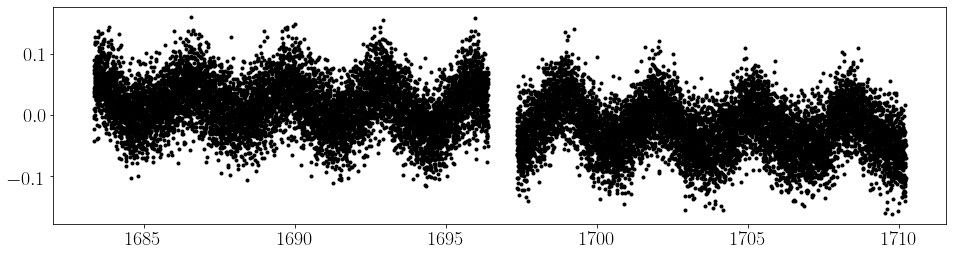

In [3]:
fig = plt.figure(figsize=(16, 4))
plt.plot(lc.time, lc.flux, "k.")

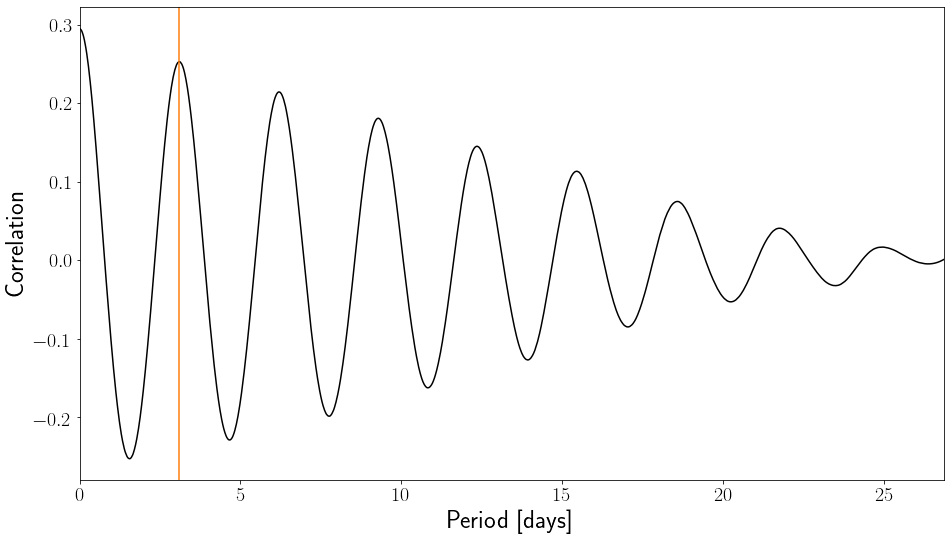

In [4]:
rotate = ss.RotationModel(lc.time.values, lc.flux.values, np.ones_like(lc.flux.values)*.001)
tess_cadence = 1./24./30.  # This is a TESS 2 minute cadence star.
acf_period = rotate.acf_rotation(tess_cadence, window_length=999, polyorder=3)
rotate.acf_plot();

In [5]:
gauss_func = lambda x,sig: 1./np.sqrt(2*np.pi*sig**2) * np.exp(-0.5*(x**2)/(sig**2)) #define a Gaussian
conv_func = gauss_func(np.arange(-28,28,1.),9.) #create the smoothing kernel
acf_smooth = np.convolve(rotate.acf, conv_func, mode='same') #and convolve

In [6]:
acf, lags = acf_smooth, rotate.lags

In [13]:
def find_all_peaks(x, y):
    
    # Array of peak indices
    peaks = np.array([i for i in range(1, len(y)-1) if y[i-1] <
                      y[i] and y[i+1] < y[i]])

    # extract peak values
    x_peaks = x[peaks]
    y_peaks = y[peaks]
    
    # sort by height
    inds = np.argsort(y_peaks)
    x_peaks, y_peaks = x_peaks[inds][::-1], y_peaks[inds][::-1]
    
    return x_peaks, y_peaks

def find_peaks_at_integers(period, peak_positions):
    """
    A function to identify the positions of the peaks that lie within
    10% of an integer multiple of the period.
    
    Args:
        period (float): The best estimate of the rotation period
        peak_positions (array): an array of the times of peaks in an ACF
        
    Returns:
        good_peaks (array): The positions of peaks near integer multiples.
        errs (array): an array containing the differences between the peak positions 
            and the integer multiple of the period
    """

    # Calculate the modulus
    mods = peak_positions % period
    
    # Shift mods to make more Gaussian
    corrected_mods = mods*1
    corrected_mods[corrected_mods > .5*period] -= period
    
    # Find peaks within 10% of an integer multiple of the period
    good = abs(corrected_mods) < .1*period
    good_peaks = peak_positions[good]
    errs = abs(corrected_mods)[good]
    
    return good_peaks, errs

def fit_line_to_good_peaks(good_peaks, errs):
    """
    A function that fits a line to the peak positions and pulls out a period and an uncertainty.
    
    Args:
        good_peaks (array): The positions of peaks within 10% of an integer multiple in an ACF
        errs (array): an array containing the differences between the peak positions 
            and the integer multiple of the period
            
    Returns:
        The period and uncertainty
    """
    errs[errs == 0] += .001
    x = np.arange(len(good_peaks), dtype="float64")
    y = good_peaks
    w, sig = fit_line(x, y, errs)
    return w[1], sig[1]

def fit_line(x, y, yerr):
    AT = np.vstack((np.ones(len(x)), x))
    C = np.eye(len(x))*yerr
    CA = np.linalg.solve(C, AT.T)
    Cy = np.linalg.solve(C, y)
    ATCA = np.dot(AT, CA)
    ATCy = np.dot(AT, Cy)
    w = np.linalg.solve(ATCA, ATCy)

    cov = np.linalg.inv(ATCA)
    sig = np.sqrt(np.diag(cov))
    return w, sig

In [14]:
x_peaks, y_peaks = find_all_peaks(lags, acf)
acf_period = x_peaks[1]

good_peaks, errs = find_peaks_at_integers(acf_period, x_peaks)
period, uncert = fit_line_to_good_peaks(good_peaks, errs)
print(period, uncert)

3.102097160516849 0.01913334745778569


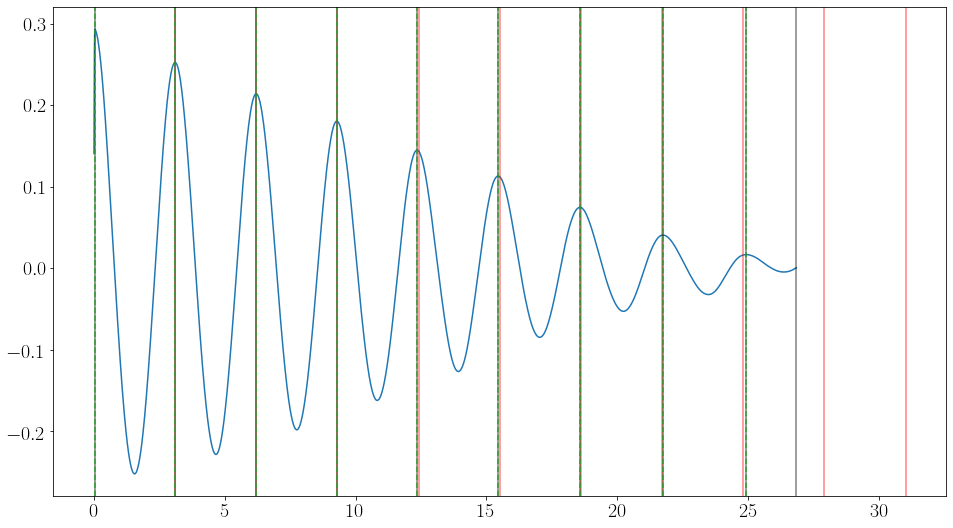

In [15]:
fig = plt.figure(figsize=(16, 9))
plt.plot(lags, acf)

for i in range(len(x_peaks[:10])):
    plt.axvline(x_peaks[i], color="k", alpha=.5)
    plt.axvline(acf_period + acf_period*i, color="r", alpha=.5)

for i in range(len(good_peaks)):
    plt.axvline(good_peaks[i], color="C2", linestyle="--")